**<span style="color: #99CCFF;">In The Name of God</span>**

---

# **<span style="color: #3D74AB;">Assignment 2</span>**

- **Parsa Bukani - 810102---**
- **Mani Hosseini - 810102---**
- **Erfan Falahati - 810102491**

In [7]:
from IPython.display import display, HTML
display(HTML('<style>pre { white-space: pre !important; }</style>'))

# <span style="color: coral;">Data Ingestion Layer</span>

## <span style="color: white;">Kafka Consumer Implementation</span>

**[Kafka Producer](producer.py)**

**[Kafka Consumer](consumer.py)**


## <span style="color: white;">Schema Management</span>
**<span style="color: #99CCFF;">The transaction data is stored in JSON by [Kafka Consumer](consumer.py) for subsequent insertion into MongoDB collections.</span>**

# <span style="color: coral;">Batch Processing Layer</span>

## <span style="color: white;">Commission Analysis Batch Job</span>


In [8]:
from pyspark.sql import SparkSession


spark = SparkSession.builder.appName("darooghe").getOrCreate()

df = spark.read.json('content/validated_transactions.json')
df.show()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/28 09:42:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+-------+-----------------+---------------+-----------+-------------+--------------------+---------------+------------------+------------------+-----------------+-----------+--------------+----------+--------+--------------------+------------+--------------------+----------+
| amount|commission_amount|commission_type|customer_id|customer_type|         device_info| failure_reason|               lat|               lng|merchant_category|merchant_id|payment_method|risk_level|  status|           timestamp|total_amount|      transaction_id|vat_amount|
+-------+-----------------+---------------+-----------+-------------+--------------------+---------------+------------------+------------------+-----------------+-----------+--------------+----------+--------+--------------------+------------+--------------------+----------+
| 467107|             9342|         tiered|   cust_300|   individual|  {NULL, NULL, NULL}|           None| 35.72415782820759| 51.32932981896976|           retail|    merch_

### <span style="color: #99CCFF;">Part I</span>


In [9]:
from pyspark.sql.functions import sum, avg, count, col, when


filtered_df = df.filter(df["status"] == "approved")

commission_analysis_df = filtered_df.select(
    "transaction_id",
    "commission_type",
    "merchant_category",
    "commission_amount",
    "total_amount",
    "amount"
)


commission_analysis_df = commission_analysis_df.groupBy("merchant_category").agg(
    sum("commission_amount").alias("total_commission"),
    avg("commission_amount").alias("avg_commission"),
    count("*").alias("transaction_count"),
    sum("amount").alias("total_transaction_amount"),
    count(when(col("commission_type") == "flat", 1)).alias("flat_count"),
    count(when(col("commission_type") == "progressive", 1)).alias("progressive_count"),
    count(when(col("commission_type") == "tiered", 1)).alias("tiered_count"),
)

commission_analysis_df = commission_analysis_df.withColumn(
    "commission_to_transaction_ratio", 
    col("total_commission") / col("total_transaction_amount")
)
commission_analysis_df.show()

25/04/28 09:42:34 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+-----------------+----------------+------------------+-----------------+------------------------+----------+-----------------+------------+-------------------------------+
|merchant_category|total_commission|    avg_commission|transaction_count|total_transaction_amount|flat_count|progressive_count|tiered_count|commission_to_transaction_ratio|
+-----------------+----------------+------------------+-----------------+------------------------+----------+-----------------+------------+-------------------------------+
|           retail|        52042054| 20569.98181818182|             2530|              2602163237|       841|              827|         862|           0.019999534717890566|
|    entertainment|        50330911|20434.799431587497|             2463|              2516604790|       823|              827|         813|           0.019999529206967775|
|     food_service|        53153979|20738.969566913773|             2563|              2657761718|       840|              837|        

### <span style="color: #99CCFF;">Part II</span>

- Commission-to-Transaction Ratio: The commission-to-transaction ratio is relatively consistent across all categories, with values ranging between 0.0199995 and 0.0200. This suggests that the commission percentage, in relation to the transaction amount, does not vary significantly across these merchant categories

- Average Commission: The average commission amount, however, shows more significant differences between the categories

Thus, merchants in the **food_service** and **retail** sectors are performing best in terms of overall commission earned, though the commission-to-transaction ratio is fairly consistent across all categories

In [10]:
data = [(row["merchant_category"], row["commission_to_transaction_ratio"], row["avg_commission"]) for row in commission_analysis_df.select(
    "merchant_category", 
    "commission_to_transaction_ratio", 
    "avg_commission"
).collect()]

sorted_data = sorted(data, key=lambda x: x[2], reverse=True)

for category, ratio, avg in sorted_data:
    print(f"Category: {category}, Commission-to-Transaction Ratio: {ratio}, Average Commission: {avg}")


Category: food_service, Commission-to-Transaction Ratio: 0.019999527662697712, Average Commission: 20738.969566913773
Category: retail, Commission-to-Transaction Ratio: 0.019999534717890566, Average Commission: 20569.98181818182
Category: transportation, Commission-to-Transaction Ratio: 0.019999512596114103, Average Commission: 20436.41267326733
Category: entertainment, Commission-to-Transaction Ratio: 0.019999529206967775, Average Commission: 20434.799431587497
Category: government, Commission-to-Transaction Ratio: 0.01999952285705948, Average Commission: 20238.842105263157


## <span style="color: white;">Transaction Pattern Analysis </span>


### <span style="color: #99CCFF;">Part I</span>

In [11]:
from pyspark.sql.functions import hour, count, minute

filtered_df = filtered_df.withColumn("hour", hour(col("timestamp")))

temporal_pattern_df = filtered_df.groupBy("hour").agg(
    count("*").alias("transaction_count")
)

temporal_pattern_df.sort(col("transaction_count").desc()).show()


+----+-----------------+
|hour|transaction_count|
+----+-----------------+
|  18|             4587|
|  17|             3066|
|   8|              246|
|  12|              245|
|   1|              242|
|  21|              242|
|  13|              234|
|  16|              231|
|  10|              231|
|   4|              229|
|  23|              227|
|   0|              227|
|   7|              226|
|   9|              225|
|  20|              223|
|  11|              222|
|   5|              219|
|   2|              214|
|  15|              211|
|   6|              209|
+----+-----------------+
only showing top 20 rows



### <span style="color: #99CCFF;">Part II</span>

In [12]:
peak_time_df = temporal_pattern_df.orderBy(col("transaction_count").desc())
peak_time_df.show(3)

+----+-----------------+
|hour|transaction_count|
+----+-----------------+
|  18|             4587|
|  17|             3066|
|   8|              246|
+----+-----------------+
only showing top 3 rows



### <span style="color: #99CCFF;">Part III</span>

In [13]:
customer_segment_df = filtered_df.groupBy("customer_id").agg(
    count("*").alias("transaction_count"),
    sum("amount").alias("total_spent")
)
customer_segment_df.sort(col("total_spent").desc()).show()

+-----------+-----------------+-----------+
|customer_id|transaction_count|total_spent|
+-----------+-----------------+-----------+
|   cust_960|               23|   26153310|
|   cust_304|               19|   24827089|
|   cust_565|               21|   23888743|
|   cust_761|               22|   23872722|
|   cust_224|               22|   23794858|
|   cust_722|               21|   23692208|
|   cust_192|               20|   23468295|
|   cust_903|               24|   23345230|
|   cust_456|               19|   23220546|
|    cust_67|               17|   23101572|
|   cust_361|               20|   23004501|
|   cust_396|               21|   22874506|
|    cust_38|               20|   22843633|
|    cust_68|               19|   22823953|
|   cust_225|               18|   22759054|
|   cust_558|               23|   22748633|
|   cust_164|               20|   22731819|
|   cust_972|               24|   22284702|
|   cust_594|               20|   22248840|
|   cust_452|               16| 

### <span style="color: #99CCFF;">Part IV</span>

In [14]:
merchant_behavior_df = filtered_df.groupBy("merchant_category").agg(
    count("*").alias("transaction_count"),
    sum("amount").alias("total_sales")
)

merchant_behavior_df.sort(col("transaction_count").desc()).show()

+-----------------+-----------------+-----------+
|merchant_category|transaction_count|total_sales|
+-----------------+-----------------+-----------+
|     food_service|             2563| 2657761718|
|           retail|             2530| 2602163237|
|   transportation|             2525| 2580159979|
|       government|             2489| 2518783991|
|    entertainment|             2463| 2516604790|
+-----------------+-----------------+-----------+



### <span style="color: #99CCFF;">Part V</span>

In [15]:
from pyspark.sql.functions import when

filtered_df = filtered_df.withColumn(
    "time_of_day",
    when((col("hour") >= 6) & (col("hour") < 12), "Morning")
    .when((col("hour") >= 12) & (col("hour") < 18), "Afternoon")
    .when((col("hour") >= 18) & (col("hour") < 24), "Evening")
    .otherwise("Night")
)

time_of_day_df = filtered_df.groupBy("time_of_day").agg(
    count("*").alias("transaction_count")
)

time_of_day_df.show()


+-----------+-----------------+
|time_of_day|transaction_count|
+-----------+-----------------+
|    Evening|             5683|
|    Morning|             1359|
|  Afternoon|             4188|
|      Night|             1340|
+-----------+-----------------+



### <span style="color: #99CCFF;">Part VI</span>

In [16]:

filtered_df = filtered_df.withColumn("hour", hour(col("timestamp")))
filtered_df = filtered_df.withColumn("minute", minute(col("timestamp")))

spending_trend_df = filtered_df.groupBy("hour", "minute").agg(
    sum("amount").alias("total_spent")
).orderBy("hour", "minute")

spending_trend_df.sort(col("total_spent").desc()).show()


+----+------+-----------+
|hour|minute|total_spent|
+----+------+-----------+
|  18|    10|  284197106|
|  18|     1|  280163593|
|  18|     5|  273873810|
|  17|    57|  272125245|
|  18|     8|  271877313|
|  18|    14|  265617938|
|  17|    59|  263711329|
|  18|    17|  262944862|
|  18|     6|  262672565|
|  17|    54|  261078688|
|  17|    49|  256030382|
|  17|    51|  255837194|
|  18|     3|  253492670|
|  18|     9|  253299909|
|  17|    56|  252730046|
|  18|    12|  249074881|
|  17|    55|  246432877|
|  17|    50|  245083044|
|  18|    11|  243754715|
|  18|    15|  242012373|
+----+------+-----------+
only showing top 20 rows



## <span style="color: white;">Data Storage Implementation</span>


### <span style="color: #99CCFF;">Part I</span>

In [17]:
from pymongo import MongoClient
from datetime import datetime

client = MongoClient("mongodb://localhost:27017/")
db = client['daroogheDB']
db.drop_collection('transactions')
transactions_collection = db['transactions']


rows = df.filter(df["status"] == "approved").collect()


documents = []
for row in rows:
    transaction = {
        "id": row['transaction_id'],
        "timestamp": datetime.fromisoformat(row['timestamp']),
        "customer_id": row['customer_id'],
        "merchant_id": row['merchant_id'],
        "lat": row['lat'],
        "long": row['lng'],
        "merchant_category": row['merchant_category'],
        "amount": row['amount'],
        "vat_amount": row['vat_amount'],
        "commission_type": row["commission_type"],
        "commission_amount": row["commission_amount"],
        "total_amount": row["total_amount"],
        "customer_type": row["customer_type"],
        "risk_level": row["risk_level"],
        "failure_reason": row["failure_reason"],
        "device_info": row["device_info"],
        "payment_method": row["payment_method"],
        "status": row["status"],
        "createdAt": datetime.utcnow(),
    }
    documents.append(transaction)

if documents:
    transactions_collection.insert_many(documents)


/tmp/ipykernel_5480/1018307240.py:34: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "createdAt": datetime.utcnow(),


### <span style="color: #99CCFF;">Part II</span>

#### <font color="#3D74AB">Create a TTL Index in MongoDB</font>

In [18]:
transactions_collection.create_index([("timestamp", 1)], expireAfterSeconds=86400)
print(transactions_collection.index_information())

{'_id_': {'v': 2, 'key': [('_id', 1)]}, 'timestamp_1': {'v': 2, 'key': [('timestamp', 1)], 'expireAfterSeconds': 86400}}


### <span style="color: #99CCFF;">Part III</span>

#### <font color="#20B2AA">Group by Merchant</font>

In [19]:
pipeline = [
    {
        "$group": {
            "_id": "$merchant_category",
            "total_sales": { "$sum": "$amount" },
            "transaction_count": { "$count": {} }
        }
    },
    { 
        "$sort": { "total_sales": -1 }
    }
]

result = transactions_collection.aggregate(pipeline)

print("merchant_category\ttotal_sales\t\ttransaction_count")
for record in result:
    print(
        f"{record['_id'].ljust(24)}"
        f"{str(record['total_sales']).ljust(24)}"
        f"{str(record['transaction_count']).ljust(10)}"
    )

merchant_category	total_sales		transaction_count
food_service            2657761718              2563      
retail                  2602163237              2530      
transportation          2580159979              2525      
government              2518783991              2489      
entertainment           2516604790              2463      


#### <font color="#20B2AA">Group by Customer Segment</font>

In [20]:
pipeline = [
    {
        "$group": {
            "_id": "$customer_type",
            "total_sales": { "$sum": "$amount" },
            "transaction_count": { "$count": {} }
        }
    },
    {
        "$sort": { "total_sales": -1 } 
    }
]

result = transactions_collection.aggregate(pipeline)

print("customer_type\t\ttotal_sales\t\ttransaction_count")
for record in result:
    print(
        f"{record['_id'].ljust(24)}"
        f"{str(record['total_sales']).ljust(24)}"
        f"{str(record['transaction_count']).ljust(10)}"
    )

customer_type		total_sales		transaction_count
business                4411839808              4253      
individual              4235542121              4178      
CIfunctionP             4228091786              4139      


### <font color="#3D74AB">Summarized transaction data</font>

In [21]:
pipeline = [
    {
        "$project": {
            "hour": { 
                "$dateToString": { 
                    "format": " %H:00", 
                    "date": "$timestamp",
                }
            },
            "amount": 1
        }
    },
    {
        "$group": {
            "_id": "$hour", 
            "total_sales": { "$sum": "$amount" },
            "transaction_count": { "$count": {} }
        }
    },
    {
        "$sort": { "_id": 1 }  
    }
]

result = transactions_collection.aggregate(pipeline)

print("hour\t\t\ttotal_sales\ttransaction_count")
for record in result:
    print(
        f"{record['_id'].ljust(24)}"
        f"{str(record['total_sales']).ljust(24)}"
        f"{str(record['transaction_count']).ljust(10)}"
    )



hour			total_sales	transaction_count
 00:00                  244493954               238       
 01:00                  227326885               217       
 02:00                  229379986               221       
 03:00                  231740880               217       
 04:00                  235535789               234       
 05:00                  251446588               242       
 06:00                  242791849               222       
 07:00                  212350996               226       
 08:00                  242524198               233       
 09:00                  241015583               240       
 10:00                  217213577               208       
 11:00                  209528316               205       
 12:00                  232098031               230       
 13:00                  246346872               224       
 14:00                  7593527417              7432      
 15:00                  219327351               217       
 16:00             

### <font color="#3D74AB">Commission Reports</font>

In [22]:
pipeline = [
    {
        "$project": {
            "hour": { 
                "$dateToString": { 
                    "format": "%H:00",
                    "date": "$timestamp",
                }
            },
            "merchant_category": 1,
            "commission_amount": 1
        }
    },
    {
        "$group": {
            "_id": { 
                "merchant_category": "$merchant_category", 
                "hour": "$hour" 
            },
            "total_commission": { "$sum": "$commission_amount" }
        }
    },
    {
        "$sort": { "_id.hour": 1 } 
    }
]

result = transactions_collection.aggregate(pipeline)

print("hour\t\t\tmerchant_category\ttotal_commission")
for record in result:
    print(
        f"{record['_id']['hour'].ljust(24)}"
        f"{record['_id']['merchant_category'].ljust(24)}"
        f"{str(round(record['total_commission'], 2)).ljust(10)}"
    )



hour			merchant_category	total_commission
00:00                   food_service            788195    
00:00                   entertainment           1080771   
00:00                   transportation          1041413   
00:00                   retail                  919197    
00:00                   government              1060187   
01:00                   retail                  719015    
01:00                   entertainment           891648    
01:00                   food_service            680102    
01:00                   transportation          1072658   
01:00                   government              1183004   
02:00                   food_service            666867    
02:00                   government              1181896   
02:00                   transportation          835978    
02:00                   retail                  1010247   
02:00                   entertainment           892509    
03:00                   government              780638    
03:00         

# <span style="color: coral;">Visualization</span>

In [23]:
import pandas as pd

client = MongoClient("mongodb://localhost:27017/")
db = client['daroogheDB']
transactions_collection = db['transactions']

transactions = list(transactions_collection.find())
df = pd.DataFrame(transactions)


## <span style="color: #99CCFF;">Part I</span>
#### <span style="color: #3D74AB;">Transaction Volume Over Time</span>

**The peak traffic for transactions occurs around 2:30 PM, and at other times, the number of transactions remains relatively stable.**


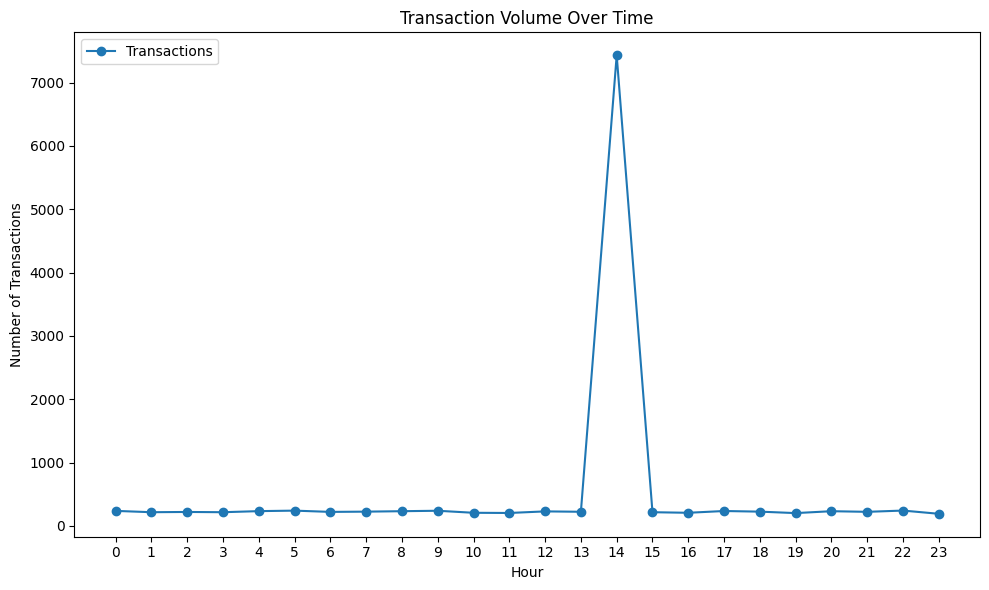

In [24]:
import matplotlib.pyplot as plt

volume_per_day = df.groupby(df['timestamp'].dt.hour).size()


plt.figure(figsize=(10, 6))
volume_per_day.plot(kind='line', label='Transactions', marker='o')
plt.title('Transaction Volume Over Time')
plt.xlabel('Hour')
plt.xticks(range(0, 24))
plt.ylabel('Number of Transactions')
plt.legend(loc='upper left') 
plt.tight_layout()
plt.show()



## <span style="color: #99CCFF;">Part II</span>
### <span style="color: #3D74AB;">Merchant Analysis</span>

**According to the chart, the highest number of transactions performed by a user is approximately between 250 and 300 transactions.**

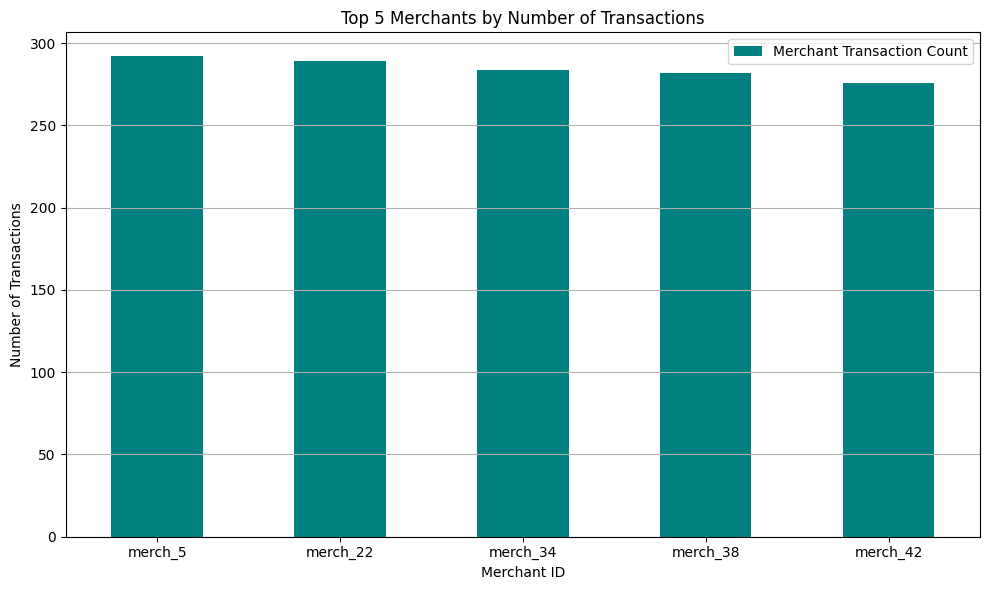

In [30]:
top_merchants = df['merchant_id'].value_counts().head(5)

plt.figure(figsize=(10, 6))
top_merchants.plot(kind='bar', color='teal', label='Merchant Transaction Count')
plt.title('Top 5 Merchants by Number of Transactions')
plt.xlabel('Merchant ID')
plt.ylabel('Number of Transactions')
plt.legend(loc='upper right') 
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## <span style="color: #99CCFF;">Part III</span>
### <span style="color: #3D74AB;">User Activity</span>

**We observe that the number of users who perform a specific number of transactions follows a normal distribution with a mean of 12.57 and a variance of 12.35.**


mean: 12.57
variance: 12.349449449449452


TypeError: Legend.__init__() got an unexpected keyword argument 'l20B2AAoc'

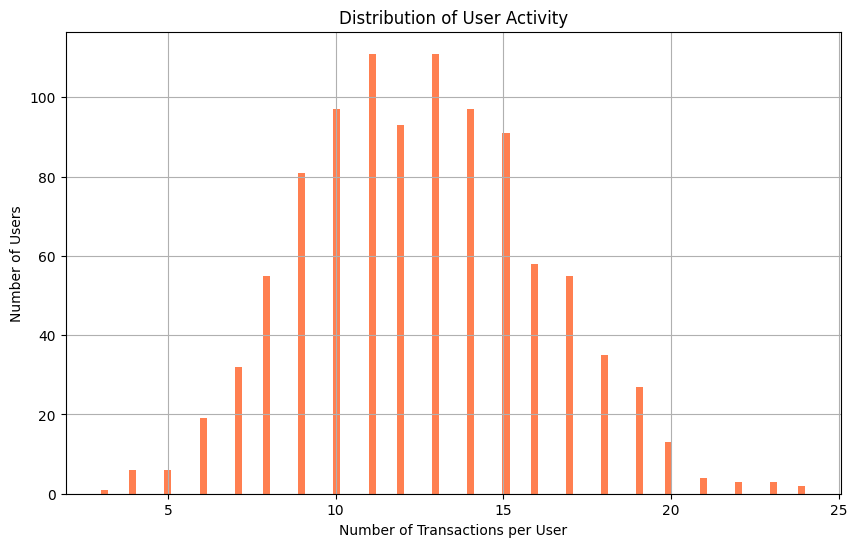

In [ ]:
transactions_per_user = df['customer_id'].value_counts()

print("mean:",transactions_per_user.mean())
print("variance:",transactions_per_user.var())
plt.figure(figsize=(10, 6))
transactions_per_user.hist(bins=100, color='coral', label='Users')
plt.title('Distribution of User Activity')
plt.xlabel('Number of Transactions per User')
plt.ylabel('Number of Users')
plt.legend(loc='upper right') 
plt.grid(True)
plt.tight_layout()
plt.show()



**According to the chart, we see that initially, from 24:00 to 12:00 PM, the growth trend of the number of users is negative, and from 12:00 PM to 3:00 PM, there is a significant increase. After 3:00 PM, the downward trend begins and continues until 12:00 AM.**

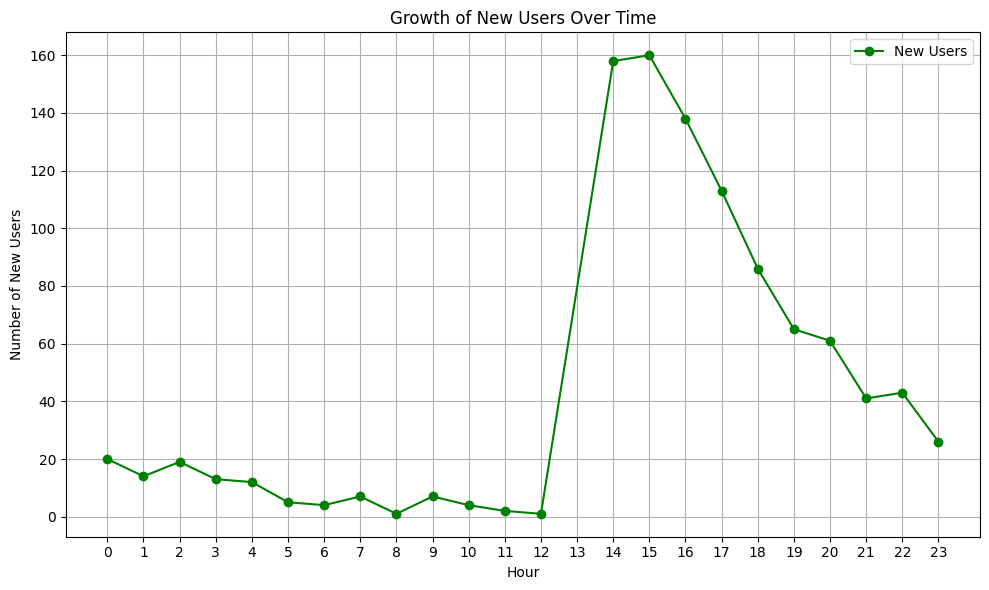

In [27]:
first_tx_per_user = df.groupby('customer_id')['timestamp'].min()

new_users_per_day = first_tx_per_user.groupby(first_tx_per_user.dt.hour).count()

plt.figure(figsize=(10, 6))
new_users_per_day.plot(kind='line', marker='o', color='green', label='New Users')
plt.title('Growth of New Users Over Time')
plt.xlabel('Hour')
plt.xticks(range(0, 24))
plt.ylabel('Number of New Users')
plt.legend(loc='upper right') 
plt.grid(True)
plt.tight_layout()
plt.show()

